#### 方案2：ConvLSTM——通过窗口直接预测未来三帧图像

### 数据预处理

  实现了图像数据的加载、排序和数据集的定义。主要包括从目录中加载图像文件，按文件名中的数字排序，并将图像数据划分为训练集和验证集。然后定义一个自定义的PyTorch数据集类，用于加载和处理图像序列数据，并创建数据加载器。

### 函数详细描述

#### 1. extract_number(filename)
- **功能**: 使用正则表达式从文件名中提取数字。
- **输入**: 
  - `filename` (str) - 文件名。
- **输出**: 
  - 提取到的数字 (int)，如果没有找到则返回0。
- **实现思路**:
  - 使用正则表达式匹配文件名中的数字部分。
  - 返回匹配到的数字。

#### 2. load_images_sorted(directory)
- **功能**: 加载指定目录中的所有图像文件，并按文件名中的数字排序。
- **输入**:
  - `directory` (str) - 包含图像文件的目录。
- **输出**: 
  - 按文件名中的数字排序后的图像文件路径列表 (list)。
- **实现思路**:
  - 使用`os.listdir`遍历目录，找到所有以“.jpg”结尾的文件并加入列表。
  - 使用`extract_number`函数对文件名进行排序。

### 数据集和数据加载器的定义

1. **图像数据的加载和划分**:
   - 使用`load_images_sorted`函数加载目录中的所有图像文件，并按80%用于训练，20%用于验证的比例进行划分。

2. **定义数据集类**:
   - 定义一个自定义的PyTorch数据集类`TyphoonDataset`，用于加载和处理图像序列数据。

3. **创建数据加载器**:
   - 使用`DataLoader`创建训练集和验证集的数据加载器，设置批量大小为10。

In [2]:
import os
import re
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

def extract_number(filename):
    # 使用正则表达式从文件名中提取数字
    match = re.search(r'\d+', filename)
    return int(match.group()) if match else 0

def load_images_sorted(directory):
    # 加载图像，并按文件名中的数字进行排序
    images = []
    for fname in os.listdir(directory):
        if fname.endswith('.jpg'):  # 确保只处理.jpg文件
            full_path = os.path.join(directory, fname)
            images.append(full_path)
    images.sort(key=extract_number)  # 使用提取的数字排序
    return images

# 示例用法
directory = '/root/dashuju/data2'
all_images = load_images_sorted(directory)
split_point = int(len(all_images) * 0.8)  # 计算分割点，80%用于训练
train_images = all_images[:split_point]
val_images = all_images[split_point:]

### 2. 定义数据集类
class TyphoonDataset(Dataset):
    def __init__(self, image_paths, sequence_length=8, prediction_length=3, transform=None):
        self.image_paths = image_paths
        self.sequence_length = sequence_length
        self.prediction_length = prediction_length
        self.transform = transform or transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return len(self.image_paths) - self.sequence_length - self.prediction_length + 1

    def __getitem__(self, idx):
        sequence_paths = self.image_paths[idx:idx + self.sequence_length + self.prediction_length]
        imgs = [Image.open(img_path).convert('RGB') for img_path in sequence_paths]
        if self.transform:
            imgs = [self.transform(img) for img in imgs]
        sequences = torch.stack(imgs[:self.sequence_length])
        targets = torch.stack(imgs[self.sequence_length:])
        
        # 输出 sequences 和 targets 的形状
        # print(f'Sequences shape: {sequences.shape}, Targets shape: {targets.shape}')
        
        return sequences, targets

# 创建数据加载器
train_dataset = TyphoonDataset(train_images)
val_dataset = TyphoonDataset(val_images)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# 检查一批数据的形状
for sequences, targets in train_loader:
    # print("Batch Sequences shape:", sequences.shape)  # 应为 (batch_size, seq_len, channels, height, width)
    # print("Batch Targets shape:", targets.shape)  # 应为 (batch_size, prediction_length, channels, height, width)
    break  # 只展示第一批数据的形状


### 定义模型

  实现实现卷积长短时记忆网络（ConvLSTM）.ConvLSTMCell是基本单元，结合卷积操作处理图像序列，ConvLSTM则堆叠多个ConvLSTMCell实现深度网络，能够输入图像序列并预测未来图像。

### 函数详细描述

#### 1. ConvLSTMCell
- **功能**: 定义一个ConvLSTM细胞，用于处理输入的图像序列并更新隐藏状态。
- **输入**:
  - `input_dim` (int) - 输入的通道数。
  - `hidden_dim` (int) - 隐藏状态的通道数。
  - `kernel_size` (tuple) - 卷积核的大小。
  - `bias` (bool) - 是否使用偏置。
- **输出**:
  - `h_next` (Tensor) - 下一时间步的隐藏状态，形状为(batch_size, hidden_dim, height, width)。
  - `c_next` (Tensor) - 下一时间步的记忆状态，形状为(batch_size, hidden_dim, height, width)。
- **实现思路**:
  - 初始化卷积层，用于处理输入和隐藏状态的拼接。
  - 在`forward`方法中，将输入和当前隐藏状态拼接，经过卷积层得到四个门控信号。
  - 通过sigmoid和tanh函数计算输入门、遗忘门、输出门和新的记忆状态。
  - 更新记忆状态和隐藏状态并返回。

#### 2. init_hidden(batch_size, image_size)
- **功能**: 初始化隐藏状态和记忆状态。
- **输入**:
  - `batch_size` (int) - 批次大小。
  - `image_size` (Tuple[int, int]) - 图像的高度和宽度。
- **输出**: 
  - 初始化的隐藏状态和记忆状态，形状均为(batch_size, hidden_dim, height, width)。
- **实现思路**:
  - 创建全零张量作为初始隐藏状态和记忆状态。

#### 3. ConvLSTM
- **功能**: 定义一个多层ConvLSTM网络，用于处理图像序列并生成预测结果。
- **输入**:
  - `input_dim` (int) - 输入的通道数。
  - `hidden_dim` (list) - 每一层隐藏状态的通道数。
  - `kernel_size` (tuple) - 卷积核的大小。
  - `num_layers` (int) - ConvLSTM的层数。
  - `output_dim` (int) - 输出的通道数。
  - `bias` (bool) - 是否使用偏置。
- **输出**:
  - `predictions` (Tensor) - 最终的预测结果，形状为(batch_size, predict_steps, output_dim, height, width)。
  - `last_state_list` (List[Tuple[Tensor, Tensor]]) - 每一层最后的隐藏状态和记忆状态。
- **实现思路**:
  - 在初始化时创建一个ConvLSTMCell的列表，每层一个。
  - 在`forward`方法中，遍历输入序列并在每一层上进行时间步的循环，更新每一层的隐藏状态和记忆状态。
  - 使用卷积层将最后一层的输出转换为预测结果。

#### 4. _init_hidden(batch_size, image_size)
- **功能**: 初始化所有层的隐藏状态和记忆状态。
- **输入**:
  - `batch_size` (int) - 批次大小。
  - `image_size` (Tuple[int, int]) - 图像的高度和宽度。
- **输出**:
  - `init_states` (List[Tuple[Tensor, Tensor]]) - 包含每一层的初始隐藏状态和记忆状态。
- **实现思路**:
  - 调用每一层的init_hidden方法，初始化隐藏状态和记忆状态。

In [4]:
"""2"""
import torch
import torch.nn as nn

class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super(ConvLSTMCell, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias
        
        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        
        combined = torch.cat([input_tensor, h_cur], dim=1)
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, output_dim, bias=True):
        super(ConvLSTM, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.output_dim = output_dim
        self.bias = bias
        self.cell_list = nn.ModuleList()
        
        for i in range(self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i-1]
            self.cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                               hidden_dim=self.hidden_dim[i],
                                               kernel_size=self.kernel_size,
                                               bias=self.bias))
        
        self.conv = nn.Conv2d(in_channels=self.hidden_dim[-1],
                              out_channels=self.output_dim,
                              kernel_size=3,
                              padding=1,
                              bias=True)

    def forward(self, input_tensor, hidden_state=None, predict_steps=3):
        b, seq_len, _, h, w = input_tensor.size()
        if hidden_state is None:
            hidden_state = self._init_hidden(batch_size=b, image_size=(h, w))
        
        layer_output_list = []
        last_state_list = []

        cur_layer_input = input_tensor
        for layer_idx in range(self.num_layers):
            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :], cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append((h, c))

        predictions = []
        cur_input = layer_output_list[-1][:, -1, :, :, :]
        for _ in range(predict_steps):
            h_next, c_next = last_state_list[-1]
            h, c = self.cell_list[-1](input_tensor=cur_input, cur_state=[h_next, c_next])
            cur_input = h
            predictions.append(self.conv(h))

        predictions = torch.stack(predictions, dim=1)
        return predictions, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states


### 预测模块

#### 超参数设定
- **epochs** (int) - 训练的周期数。
- **learning_rate** (float) - 学习率。
- **hidden_dim** (list) - 每一层隐藏状态的通道数。
- **kernel_size** (tuple) - 卷积核的大小。
- **num_layers** (int) - ConvLSTM的层数。
- **output_dim** (int) - 输出的通道数。

#### 初始化模型、损失函数和优化器
- **功能**: 定义ConvLSTM模型结构，选择损失函数和优化算法。
- **实现思路**:
  - 使用定义好的ConvLSTM模型类初始化模型结构。
  - 使用MSELoss作为损失函数。
  - 使用Adam优化器，并设置学习率。
  - 如果有GPU，使用`model.cuda()`将模型移至GPU。

#### 训练和验证过程
- **功能**: 对模型进行训练，并记录每个epoch的训练和验证损失。
- **实现思路**:
  - 将模型设置为训练模式`model.train()`。
  - 对每个batch进行前向传播、计算损失、反向传播和优化器更新。
  - 累加每个batch的训练损失，并计算平均损失。
  - 将模型设置为评估模式`model.eval()`。
  - 禁用梯度计算，减少内存使用。
  - 对每个batch进行前向传播和损失计算。
  - 累加每个batch的验证损失，并计算平均损失。
  - 在每个epoch结束后，打印当前epoch的训练和验证损失。

#### 绘制训练和验证损失曲线
- **功能**: 绘制训练和验证过程中的损失曲线，以评估模型的表现。
- **实现思路**:
  - 使用Matplotlib绘制训练和验证损失曲线。
  - 设置x轴为epoch，y轴为loss，并添加图例。

Epoch 1/30, Train Loss: 4.6694, Validation Loss: 0.4038
Epoch 2/30, Train Loss: 2.3231, Validation Loss: 0.3463
Epoch 3/30, Train Loss: 1.4530, Validation Loss: 0.2911
Epoch 4/30, Train Loss: 1.3526, Validation Loss: 0.2869
Epoch 5/30, Train Loss: 1.3071, Validation Loss: 0.2834
Epoch 6/30, Train Loss: 1.2478, Validation Loss: 0.2771
Epoch 7/30, Train Loss: 1.1796, Validation Loss: 0.2755
Epoch 8/30, Train Loss: 1.1128, Validation Loss: 0.2707
Epoch 9/30, Train Loss: 1.0760, Validation Loss: 0.2687
Epoch 10/30, Train Loss: 1.0474, Validation Loss: 0.2663
Epoch 11/30, Train Loss: 1.0123, Validation Loss: 0.2646
Epoch 12/30, Train Loss: 0.9860, Validation Loss: 0.2627
Epoch 13/30, Train Loss: 0.9653, Validation Loss: 0.2609
Epoch 14/30, Train Loss: 0.9439, Validation Loss: 0.2592
Epoch 15/30, Train Loss: 0.9236, Validation Loss: 0.2577
Epoch 16/30, Train Loss: 0.9059, Validation Loss: 0.2566
Epoch 17/30, Train Loss: 0.8913, Validation Loss: 0.2557
Epoch 18/30, Train Loss: 0.8799, Validat

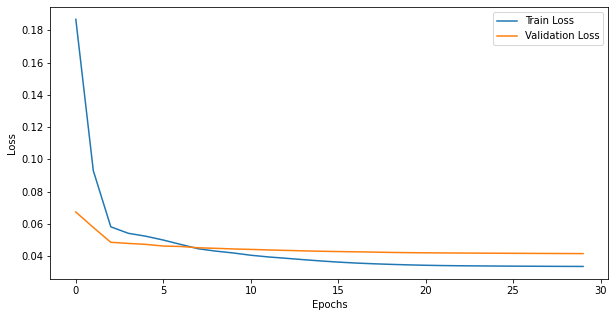

In [5]:
import torch.optim as optim
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

# 设定超参数
epochs = 30
learning_rate = 1e-3
#learning_rate = 1e-5
hidden_dim = [64, 64]
kernel_size = (1, 1)
num_layers = 2
output_dim = 1

# 初始化模型
model = ConvLSTM(input_dim=1,
                 hidden_dim=hidden_dim,
                 kernel_size=kernel_size,
                 num_layers=num_layers,
                 output_dim=output_dim,
                 bias=True)

model = model.cuda()  # 如果有GPU的话
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 训练和验证过程
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for sequences, targets in train_loader:
        sequences = sequences.cuda()  # 如果有GPU的话
        targets = targets.cuda()  # 如果有GPU的话
        
        optimizer.zero_grad()
        outputs, _ = model(sequences)

        # 计算三个预测帧的损失平均值
        loss = sum(criterion(outputs[:, i], targets[:, i]) for i in range(targets.size(1))) / targets.size(1)
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))
    # print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}')

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for sequences, targets in val_loader:
            sequences = sequences.cuda()  # 如果有GPU的话
            targets = targets.cuda()  # 如果有GPU的话
            
            outputs, _ = model(sequences)
            loss = sum(criterion(outputs[:, i], targets[:, i]) for i in range(targets.size(1))) / targets.size(1)
            val_loss += loss.item()

    val_losses.append(val_loss / len(val_loader))
    # print(f'Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss:.4f}')
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')


# 绘制训练和验证损失曲线
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [7]:
import torch

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, '/root/dashuju/model/model1.pth')


### 预测及绘图
#### 1. extract_number(filename)
- **功能**: 使用正则表达式从文件名中提取数字。
- **输入**: `filename` (str) - 文件名。
- **输出**: 提取到的数字 (int)。如果没有找到则返回0。
- **实现思路**:
  - 使用正则表达式匹配文件名中的数字部分。
  - 返回匹配到的数字。

#### 2. load_images_sorted(directory)
- **功能**: 加载指定目录中的所有图像文件，并按文件名中的数字排序。
- **输入**: `directory` (str) - 包含图像文件的目录。
- **输出**: 按文件名中的数字排序后的图像文件路径列表 (list)。
- **实现思路**:
  - 使用`os.listdir`遍历目录，找到所有以“.jpg”结尾的文件并加入列表。
  - 使用`extract_number`函数对文件名进行排序。

#### 3. TyphoonDataset
- **功能**: 定义一个自定义的PyTorch数据集类，用于加载和处理图像序列数据。
- **输入**:
  - `image_paths` (list) - 图像文件路径列表。
  - `sequence_length` (int) - 序列长度。
  - `prediction_length` (int) - 预测长度。
  - `transform` (callable) - 图像转换方法。
- **输出**: 
  - `__len__` - 返回数据集长度。
  - `__getitem__` - 返回给定索引处的图像序列和目标图像。
- **实现思路**:
  - 初始化时接收图像路径列表、序列长度、预测长度和图像转换方法。
  - `__len__`方法返回数据集长度。
  - `__getitem__`方法返回给定索引处的图像序列和目标图像。

#### 4. plot_predictions(real_images, predicted_images, storm_ids, times, title='Comparison')
- **功能**: 绘制真实图像和预测图像之间的比较。
- **输入**:
  - `real_images` (list) - 真实图像列表（地面真值）。
  - `predicted_images` (list) - 模型预测的图像列表。
  - `storm_ids` (list) - 暴风雨ID的列表，用于标题。
  - `times` (list) - 相对时间的列表，用于标题。
  - `title` (str) - 绘图的标题。
- **输出**: 无。
- **实现思路**:
  - 创建子图，并绘制每个图像。
  - 显示每张图像的标题和评估指标。
  - 保存比较图像。

#### 5. calculate_metrics(real_images, predicted_images)
- **功能**: 计算模型预测图像与真实图像之间的评估指标（MSE、PSNR、SSIM）。
- **输入**:
  - `real_images` (list) - 真实图像列表。
  - `predicted_images` (list) - 模型预测的图像列表。
- **输出**: 
  - `mse_list` (list) - MSE评估指标列表。
  - `psnr_list` (list) - PSNR评估指标列表。
  - `ssim_list` (list) - SSIM评估指标列表。
- **实现思路**:
  - 对每对真实图像和预测图像，计算MSE、PSNR和SSIM。
  - 返回每个评估指标的列表。

###保存模型参数

In [8]:
import matplotlib.pyplot as plt

def plot_predictions(real_images, predicted_images, title='对比'):
    """
    该函数绘制真实图像和模型预测图像之间的对比。
    :param real_images: 真实图像的列表（真实值）。
    :param predicted_images: 模型预测的图像列表。
    :param title: 图像的标题。
    """
    num_images = len(real_images)
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 3, 6))
    for i in range(num_images):
        # 显示真实图像
        axes[0, i].imshow(real_images[i].squeeze(), cmap='gray')
        axes[0, i].set_title(f'真实图像 {i+1}')
        axes[0, i].axis('off')

        # 显示预测图像
        axes[1, i].imshow(predicted_images[i].squeeze(), cmap='gray')
        axes[1, i].set_title(f'预测图像 {i+1}')
        axes[1, i].axis('off')

    plt.suptitle(title)
    plt.show()

Avg-MSE：0.0123
Avg-PSNR：21.6973 dB
Avg-SSIM：0.6816


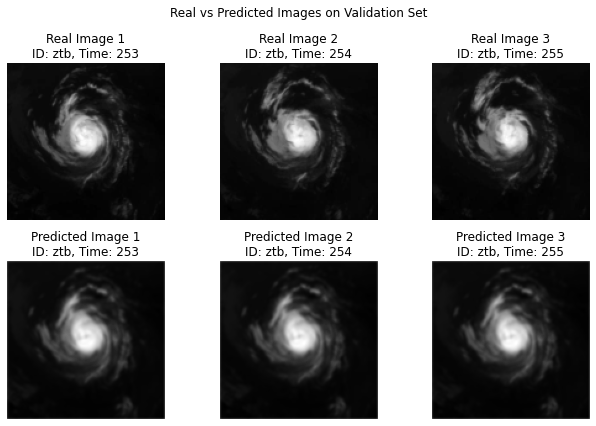

In [13]:
import matplotlib.pyplot as plt
import os
import torch
import numpy as np
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity

def plot_predictions(real_images, predicted_images, storm_ids, times, title='Comparison'):
    """
    该函数绘制真实图像和预测图像之间的比较。
    :param real_images: 真实图像列表（地面真值）。
    :param predicted_images: 模型预测的图像列表。
    :param storm_ids: 暴风雨ID的列表，用于标题。
    :param times: 相对时间的列表，用于标题。
    :param title: 绘图的标题。
    """
    num_images = len(real_images)
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 3, 6))
    
    for i in range(num_images):
        # 显示真实图像
        real_img = real_images[i].squeeze()  # 去掉批次和通道维度
        if real_img.ndim == 2:
            axes[0, i].imshow(real_img, cmap='gray')
        else:
            axes[0, i].imshow(real_img, cmap='gray')
        axes[0, i].set_title(f'Real Image {i+1}\nID: {storm_ids[i]}, Time: {times[i]}')
        axes[0, i].axis('off')

        # 显示预测图像
        pred_img = predicted_images[i].squeeze()  # 去掉批次和通道维度
        if pred_img.ndim == 2:
            axes[1, i].imshow(pred_img, cmap='gray')
        else:
            axes[1, i].imshow(pred_img, cmap='gray')
        axes[1, i].set_title(f'Predicted Image {i+1}\nID: {storm_ids[i]}, Time: {times[i]}')
        axes[1, i].axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def calculate_metrics(real_images, predicted_images):
    mse_list = []
    psnr_list = []
    ssim_list = []

    for real_img, pred_img in zip(real_images, predicted_images):
        mse = mean_squared_error(real_img, pred_img)
        psnr = peak_signal_noise_ratio(real_img, pred_img, data_range=pred_img.max() - pred_img.min())
        ssim = structural_similarity(real_img, pred_img, data_range=pred_img.max() - pred_img.min())
        
        mse_list.append(mse)
        psnr_list.append(psnr)
        ssim_list.append(ssim)
    
    avg_mse = np.mean(mse_list)
    avg_psnr = np.mean(psnr_list)
    avg_ssim = np.mean(ssim_list)

    print(f'Avg-MSE：{avg_mse:.4f}')
    print(f'Avg-PSNR：{avg_psnr:.4f} dB')
    print(f'Avg-SSIM：{avg_ssim:.4f}')
    
    return mse_list, psnr_list, ssim_list

# 设定设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 选择一个样本来预测其未来的图像
val_sequences, val_targets = next(iter(val_loader))

# 获取最后一个序列（这将是我们预测的基础）
last_sequence = val_sequences[-1:].to(device)

# 使用模型进行预测
model.eval()
with torch.no_grad():
    predicted, _ = model(last_sequence)

# 将预测结果和真实结果移至 CPU 并转为 numpy 数组以便绘制
predicted = predicted.cpu().numpy()
real = val_targets[-1].cpu().numpy()

# 调整预测和真实图像为列表，处理维度问题
predicted_images = [predicted[0, i, 0, :, :] for i in range(predicted.shape[1])]
real_images = [real[i, 0, :, :] for i in range(real.shape[0])]

# 从文件名中提取暴风雨ID和相对时间以用于绘制
sequence_length = 10
prediction_length = 3
example_start_idx = len(val_dataset.image_paths) - len(real_images) - sequence_length - prediction_length
example_indices = range(example_start_idx, example_start_idx + len(real_images))
storm_ids = [os.path.basename(val_dataset.image_paths[idx + sequence_length]).split('_')[0] for idx in example_indices]
times = [os.path.basename(val_dataset.image_paths[idx + sequence_length]).split('_')[1].split('.')[0] for idx in example_indices]

# 计算并打印评估指标
mse_list, psnr_list, ssim_list = calculate_metrics(real_images, predicted_images)

# 绘制比较结果
plot_predictions(real_images, predicted_images, storm_ids, times, title='Real vs Predicted Images on Validation Set')


In [14]:
print("Predicted shape:", predicted.shape)
print("Real shape:", real.shape)

Predicted shape: (1, 3, 1, 128, 128)
Real shape: (3, 1, 128, 128)


### 测试集图像

Saved comparison figure to /root/dashuju/images/comparison_figure.png


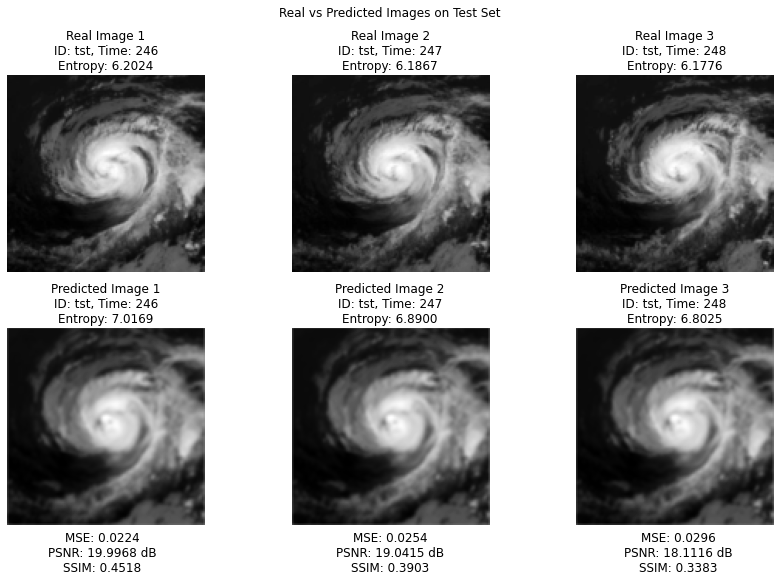

In [20]:
import os
import re
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
from scipy.stats import entropy

# 使用正则表达式从文件名中提取数字
def extract_number(filename):
    match = re.search(r'\d+', filename)
    return int(match.group()) if match else 0

# 加载图像，并按文件名中的数字进行排序
def load_images_sorted(directory):
    images = []
    for fname in os.listdir(directory):
        if fname.endswith('.jpg'):
            full_path = os.path.join(directory, fname)
            images.append(full_path)
    images.sort(key=extract_number)
    return images

# 数据集类定义
class TyphoonDataset(Dataset):
    def __init__(self, image_paths, sequence_length=10, prediction_length=3, transform=None):
        self.image_paths = image_paths
        self.sequence_length = sequence_length
        self.prediction_length = prediction_length
        self.transform = transform or transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return len(self.image_paths) - self.sequence_length - self.prediction_length + 1

    def __getitem__(self, idx):
        sequence_paths = self.image_paths[idx:idx + self.sequence_length + self.prediction_length]
        imgs = [Image.open(img_path).convert('RGB') for img_path in sequence_paths]
        if self.transform:
            imgs = [self.transform(img) for img in imgs]
        sequences = torch.stack(imgs[:self.sequence_length])
        targets = torch.stack(imgs[self.sequence_length:])
        return sequences, targets

# 路径定义
directory = '/root/dashuju/test'
all_images = load_images_sorted(directory)
split_point = int(len(all_images) * 0.8)
train_images = all_images[:split_point]
val_images = all_images[split_point:]

# 创建数据加载器
train_dataset = TyphoonDataset(train_images)
val_dataset = TyphoonDataset(val_images)
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False)

# 计算信息熵
def calculate_entropy(image):
    hist, _ = np.histogram(image, bins=256, range=(0, 1))
    hist = hist / np.sum(hist)
    e = entropy(hist, base=2)
    return e

# 创建保存目录
output_dir = "/root/dashuju/images"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 绘制预测结果和评估指标，并保存图像
def plot_predictions(real_images, predicted_images, storm_ids, times, metrics, title='Comparison'):
    num_images = len(real_images)
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 4, 8))
    
    for i in range(num_images):
        real_img = real_images[i].squeeze()
        pred_img = predicted_images[i].squeeze()
        
        if real_img.ndim == 2:
            axes[0, i].imshow(real_img, cmap='gray')
        else:
            axes[0, i].imshow(real_img)
        if pred_img.ndim == 2:
            axes[1, i].imshow(pred_img, cmap='gray')
        else:
            axes[1, i].imshow(pred_img)

        metric_text_real = f'Entropy: {metrics["entropy_real"][i]:.4f}'
        metric_text_pred = f'Entropy: {metrics["entropy_pred"][i]:.4f}'
        
        axes[0, i].set_title(f'Real Image {i+1}\nID: {storm_ids[i]}, Time: {times[i]}\n{metric_text_real}')
        axes[1, i].set_title(f'Predicted Image {i+1}\nID: {storm_ids[i]}, Time: {times[i]}\n{metric_text_pred}')
        axes[0, i].axis('off')
        axes[1, i].axis('off')

        # Placing shared metrics at the bottom of each column
        metric_text_shared = f'MSE: {metrics["mse"][i]:.4f}\nPSNR: {metrics["psnr"][i]:.4f} dB\nSSIM: {metrics["ssim"][i]:.4f}'
        fig.text((i + 0.5) / num_images, 0.00, metric_text_shared, ha='center', fontsize=12)

        # Save individual images
        plt.imsave(os.path.join(output_dir, f"real_image_{i+1}_{storm_ids[i]}_{times[i]}.png"), real_img, cmap='gray')
        plt.imsave(os.path.join(output_dir, f"predicted_image_{i+1}_{storm_ids[i]}_{times[i]}.png"), pred_img, cmap='gray')

    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.06, 1, 1])

    # Save the comparison figure
    comparison_path = os.path.join(output_dir, "comparison_figure.png")
    plt.savefig(comparison_path)
    print(f"Saved comparison figure to {comparison_path}")

    plt.show()

# 计算评估指标
def calculate_metrics(real_images, predicted_images):
    metrics = {"mse": [], "psnr": [], "ssim": [], "entropy_real": [], "entropy_pred": []}

    for real_img, pred_img in zip(real_images, predicted_images):
        mse = mean_squared_error(real_img, pred_img)
        psnr = peak_signal_noise_ratio(real_img, pred_img, data_range=pred_img.max() - pred_img.min())
        ssim = structural_similarity(real_img, pred_img, data_range=pred_img.max() - pred_img.min())
        ent_real = calculate_entropy(real_img)
        ent_pred = calculate_entropy(pred_img)
        
        metrics["mse"].append(mse)
        metrics["psnr"].append(psnr)
        metrics["ssim"].append(ssim)
        metrics["entropy_real"].append(ent_real)
        metrics["entropy_pred"].append(ent_pred)
    
    return metrics

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 选择一个样本来预测其未来的图像
val_sequences, val_targets = next(iter(val_loader))

# 获取最后一个序列（这将是我们预测的基础）
last_sequence = val_sequences[-1:].to(device)

# 使用模型进行预测
model.eval()
with torch.no_grad():
    predicted, _ = model(last_sequence)

# 将预测结果和真实结果移至 CPU 并转为 numpy 数组以便绘制
predicted = predicted.cpu().numpy()
real = val_targets[-1].cpu().numpy()

# 调整预测和真实图像为列表，处理维度问题
predicted_images = [predicted[0, i, 0, :, :] for i in range(predicted.shape[1])]
real_images = [real[i, 0, :, :] for i in range(real.shape[0])]

# 从文件名中提取暴风雨ID和相对时间以用于绘制
sequence_length = 10
prediction_length = 3
example_start_idx = len(val_dataset.image_paths) - len(real_images) - sequence_length - prediction_length
example_indices = range(example_start_idx, example_start_idx + len(real_images))
storm_ids = [os.path.basename(val_dataset.image_paths[idx + sequence_length]).split('_')[0] for idx in example_indices]
times = [os.path.basename(val_dataset.image_paths[idx + sequence_length]).split('_')[1].split('.')[0] for idx in example_indices]

# 计算并获取评估指标
metrics = calculate_metrics(real_images, predicted_images)

# 绘制比较结果
plot_predictions(real_images, predicted_images, storm_ids, times, metrics, title='Real vs Predicted Images on Test Set')


In [ ]:
import matplotlib.pyplot as plt

# 数据
time_steps = [1, 2, 3]
mse_values = [0.0224, 0.0254, 0.0296]
psnr_values = [19.9968, 19.0415, 18.1116]
ssim_values = [0.4518, 0.3903, 0.3383]

# 绘制MSE折线图
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.plot(time_steps, mse_values, marker='o', linestyle='-', color='b', label='MSE')
plt.xlabel('Image')
plt.ylabel('MSE')
plt.title('MSE')
plt.legend()
plt.grid(True)

# 绘制PSNR折线图
plt.subplot(1, 3, 2)
plt.plot(time_steps, psnr_values, marker='o', linestyle='-', color='g', label='PSNR')
plt.xlabel('Time Steps')
plt.ylabel('PSNR (dB)')
plt.title('PSNR')
plt.legend()
plt.grid(True)

# 绘制SSIM折线图
plt.subplot(1, 3, 3)
plt.plot(time_steps, ssim_values, marker='o', linestyle='-', color='r', label='SSIM')
plt.xlabel('Time Steps')
plt.ylabel('SSIM')
plt.title('SSIM')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
